# Gas Discharge & Stellar Feedback-driven Outflows (Part 2 / 2):
## Scaling, Fractional Heating, Accretion
`-- Leo Lonzarich, 31 October 2021 // [Updated 8-11-21] --`


### Table of Contents
- [Analysing Discharged Gas](#compare)
    - [Radial Position Scaling](#radialpositions)
    - [Radial Velocity Scaling](#velocities)
- [Fractional Heating](#fractional)
    - [Fraction SNe-Heated](#fractionsne)
    - [Fraction Ram Pressure-stripped](#fractionram)
- [Accretion of Discharged Gas](#accretion)
- [The Proving Grounds](#proving)


### General Comments on the Contents of this Noteboook
- Repeated pids that turn up in the data sets below (e.g. 'ejected,' 'expelled,' 'discharged') should mean that the same particle has been accreted and reejected more than once --- hence its reoccurance in the set.


- While each root data set is defined where used, definitions are included here for convenience:
    - *Ejected*: All gas partiles that have been removed from their respective satellite galaxy's disk and into the halo.
    - *Expelled*: All gas particles (either within the disk or halo of their respective satellite galaxy) that have been removed beyond the virial radius of their satellite; that is, all gas that has been completely removed from its respective satellite.
    - *Discharged*: All gas that has been removed from the disk of its respective satellite galaxy. This includes gas both moved to the halo and beyond the virial radius.
    - *predischarged*: This is essentially a data set containing the pre-properties of the discharged gas, that is, it contains all of those gas particles in the *discharged* set but with their properties before being discharged.
    - *dsrg_accreted*: **fill in**
    
    
- Units for key values used in this notebook:
    - *Time* is in Gigayears $(Gyrs)$.
    - *Distances* in kiloparsecs $(kpc)$.
    - *Velocities* in kiloparsecs per year $(kpc \ yr^{-1})$.
    - *Masses* in Solar masses $(Msol)$.

In [1]:
import numpy as np
import pylab
import pynbody
import pynbody.plot.sph as sph
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from analysis import * 

In [2]:
path = '/home/lonzaric/astro_research/Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

# listing dwarf galaxies of simulations that are viable for study (gaseous, satellite, etc).
print(len(keys), 'Available Keys:', *keys)

19 Available Keys: h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33


## The 'Discharged' Gas: Comparing Heated Vs. All <a class="anchor" id="compare"></a>

____
____

Here we commit to a similar treatment performed in *Stellar_Feedback_p1* where 'all' and 'heated' discharged gas divisions were compared. However, where we diverge here is that we scale radial positions of gas particles by the radius of their respective satellite galaxy's radius. That is, for each particle, we will have
$$
r_{eff} = r/R_{disk}
$$
for each particle, where $r_{eff}$ is the effective radius, $r$ is the radial position, and $R_{disk}$ is the radius of the relevant satellite's disk. Similarly, for velocities we commit to two different scalings
$$
v_{eff} = v/v_{vir} \text{  and  } v_{eff} = v/v_{esc} 
$$
where $v$ is the radial velocity, $v_{vir}$ is the satellite's virial velocity, and $v_{esc}$ is the escape velocity for the particle.

### Radial Position Scaling <a class="anchor" id="radialpositions"></a>

We begin by applying the scaling above for radial positions.


In [3]:
#ejected, cooled, expelled, accreted = read_all_ejected_expelled()
predischarged, discharged, accreted, preheated, heated = read_discharged()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
> Returning (predischarged, discharged, accreted, preheated, heated) for all available satellites <


In [4]:
len(predischarged), len(discharged), len(accreted), len(preheated), len(heated)

(241104, 241104, 54274, 76535, 76535)

len(predischarged), len(discharged), len(accreted), len(preheated), len(heated): 

Pre tracked particles update:

- (241104, 241104, 194090, 15229, 15229)

After updating with `Mvir` and recomputing 'accreted':

- (241104, 241104, 54274, 76535, 76535)

In [5]:
# creating weight attributes for plotting.
predischarged['weight'] = predischarged['mass'] / predischarged['mass'].sum()

discharged['weight'] = discharged['mass'] / discharged['mass'].sum()

accreted['weight'] = accreted['mass'] / accreted['mass'].sum()

preheated['weight'] = preheated['mass'] / preheated['mass'].sum()

heated['weight'] = heated['mass'] / heated['mass'].sum()

In [6]:
# data has precalculated key 'r_per_Rvir' that we will use for our position computations; we unpack it here.

pre_rR = predischarged.r_per_Rvir
all_rR = discharged.r_per_Rvir
acc_rR = accreted.r_per_Rvir
preheat_rR = preheated.r_per_Rvir
hot_rR = heated.r_per_Rvir

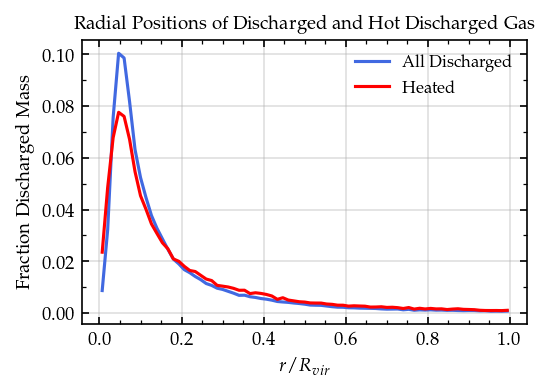

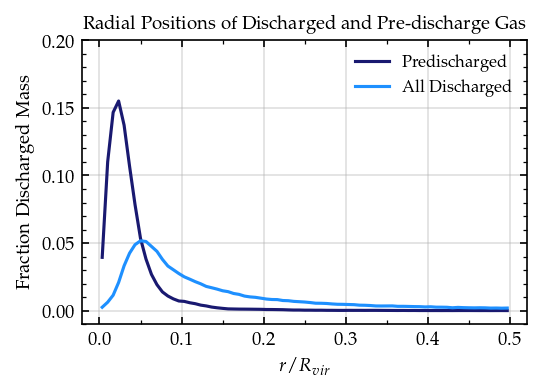

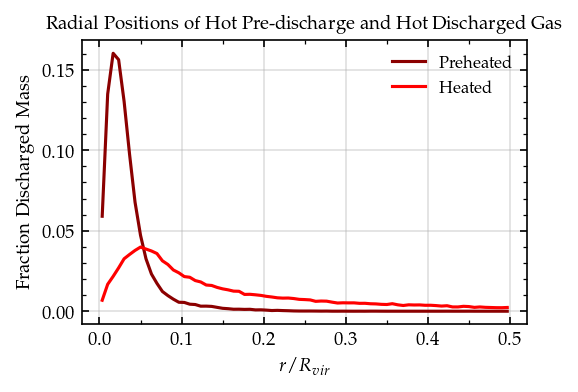

In [7]:
##### plotting discharged vs. heated gas #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.

# all discharged.
y1, x = np.histogram(all_rR, bins=bins, weights=discharged.weight, range=(0, 1.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='royalblue')

# sne-heated discharge.
y1, x = np.histogram(hot_rR, bins=bins, weights=heated.weight, range=(0, 1.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Positions of Discharged and Hot Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(0,1)
# ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))


ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting discharged vs. pre-discharged gas #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# all predischarge.
y1, x = np.histogram(pre_rR, bins=bins, weights=predischarged.weight, range=(0, 0.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Predischarged', c='midnightblue')

# all discharged.
y1, x = np.histogram(all_rR, bins=bins, weights=discharged.weight, range=(0, 0.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Positions of Discharged and Pre-discharge Gas', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(0,1)
ax.set_ylim(-0.01,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting pre-discharge heated vs. heated gas #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# sne-heated pre-discharge.
y1, x = np.histogram(preheat_rR, bins=bins, weights=preheated.weight, range=(0, 0.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Preheated', c='darkred')

# sne-heated discharge.
y1_hot, x = np.histogram(hot_rR, bins=bins, weights=heated.weight, range=(0, 0.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1_hot, label='Heated', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Positions of Hot Pre-discharge and Hot Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(0,0.2)
# ax.set_ylim(0,0.25)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')
plt.show()

**Before data recollection**: (So, the first two plots above essentially echo what we have already seen in `StellarFeedback_p1`. However, this third plot is on initial viewing, suspicious. It would appear that the radial positions for hot gas before discharge nearly match those for this gas after being discharged.)

- The minimum preheated ratio is 0.0002051885167676295 and the minimum heated ratio is  0.0005076476118961308

**After data recollection**: The distribution is far more reasonable, with a greater spread for the SNe-heated discharged particles compared to their positions before being discharged.

- The minimum preheated ratio is 0.00018167652407469122 and the minimum heated ratio is  0.0005076476118961308

So on viewing the stats on these two datasets, things would appear to be in order. Nonetheless, it is interesting to find that SNe-heated gas is discharged, on the average, only very short distances.


### Comparing Radial Velocities ($v_{vir}$)<a class="anchor" id="velocities"></a>

We first start scaling velocities according to $v_{eff} = v/v_{vir}$. Recall that the virial -- or circular -- velocity of a halo is defined by 
$$
    v_{vir} \equiv \sqrt{ \frac{G \cdot M_{vir}}{ r_{vir} } }.
$$
Thus, we use the gravitational constant $G$ as found previously and the keys `sat_Mvir` (giving the mass contained within $R_{vir}$) and `satRvir` ($R_{vir}$ for the satellite) to compute the $v_{vir}$ for every gas particle's respective satellite.

In [8]:
# gravitational constant in units of kpc**3 Msol**-1 yr**-2 (matching units of datasets here).
G = 4.53943e-24

In [9]:
# compiling virial velocities for each particle's respective satellite.
pre_vvir = np.sqrt(G * predischarged.sat_Mvir / predischarged.satRvir)
all_vvir = np.sqrt(G * discharged.sat_Mvir / discharged.satRvir)
acc_vvir = np.sqrt(G * accreted.sat_Mvir / accreted.satRvir)
hpre_vvir = np.sqrt(G * preheated.sat_Mvir / preheated.satRvir)
hot_vvir = np.sqrt(G * heated.sat_Mvir / heated.satRvir)


# creating callable key for effective velocity.
predischarged['v_per_Vvir'] = predischarged.v / pre_vvir

discharged['v_per_Vvir'] = discharged.v / all_vvir

accreted['v_per_Vvir'] = accreted.v / acc_vvir

preheated['v_per_Vvir'] = preheated.v / hpre_vvir

heated['v_per_Vvir'] = heated.v / hot_vvir

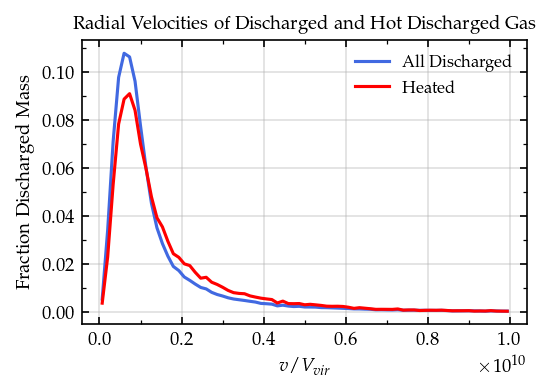

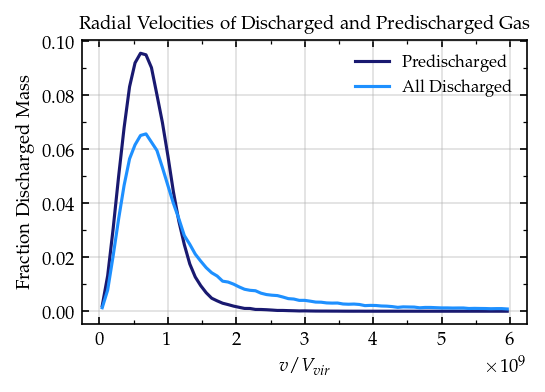

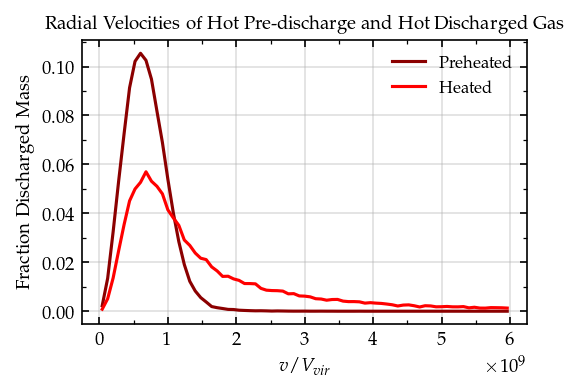

In [15]:
##### plotting all discharged vs. SNe-heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.

# all discharged.
y1, x = np.histogram(discharged.v_per_Vvir, bins=bins, weights=discharged.weight, range=(0, 1.0e10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='royalblue')

# sne-heated discharge.
y1, x = np.histogram(heated.v_per_Vvir, bins=bins, weights=heated.weight, range=(0, 1.0e10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Discharged and Hot Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(-50,150)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1e10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting all discharged vs. gas pre-discharge #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# predischarged.
y1, x = np.histogram(predischarged.v_per_Vvir, bins=bins, weights=predischarged.weight, range=(0, 0.6e10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Predischarged', c='midnightblue')

# all discharged.
y1, x = np.histogram(discharged.v_per_Vvir, bins=bins, weights=discharged.weight, range=(0, 0.6e10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Discharged and Predischarged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(-50,150)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05e10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting SNe-heated pre-discharged vs. SNe-heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# sne-heated pre-discharge.
y1, x = np.histogram(preheated.v_per_Vvir, bins=bins, weights=preheated.weight, range=(0, 0.6e10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Preheated', c='darkred')

# sne-heated discharge.
y1, x = np.histogram(heated.v_per_Vvir, bins=bins, weights=heated.weight, range=(0, 0.6e10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Hot Pre-discharge and Hot Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(-50,150)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05e10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')

plt.show()

All particles are moving out from the center of the satellites nearly uniformly. This uniformity between datasets, particularly between pre- and post-discharge... perhaps because measurements of the gas before discharge are more often than not made of the gas when it is on an exit trajectory --- this is to say, just because gas is in its satellite's disk at one timestep and not at the next (for this was the way discharged particles were located), does not mean the stripping of the particle from the satellite only occured in that short timeframe.

We should expect to see the same trend with escape velocity ratios below.

### Comparing Radial Velocities ($v_{esc}$)<a class="anchor" id="velocities"></a>

We first start scaling velocities according to $v_{eff} = v/v_{esc}$, where we can calculate the escape velocity for each particle by the familiar relation
$$
v_{esc} = \sqrt{\frac{2GM}{r}},
$$
where $G$ is the gravitational constant, $M$ is the mass contained within $R_{vir}$ of the respective satellite (again, stored in the key `sat_Mvir`), and $r$ is the radial position of the particle (key `r`).

In [11]:
# grav constant in units of kpc**3 Msol**-1 yr**-2.
G = 4.53943e10-24

In [12]:
# compiling escape velocities for each particle's respective satellite.
pre_vesc = np.sqrt(2 * G * predischarged.sat_Mvir / predischarged.r)
all_vesc = np.sqrt(2 * G * discharged.sat_Mvir / discharged.r)
acc_vesc = np.sqrt(2 * G * accreted.sat_Mvir / accreted.r)
hpre_vesc = np.sqrt(2 * G * preheated.sat_Mvir / preheated.r)
hot_vesc = np.sqrt(2 * G * heated.sat_Mvir / heated.r)


# creating callable key effective velocity.
predischarged['v_per_Vesc'] = predischarged.v / pre_vesc

discharged['v_per_Vesc'] = discharged.v / all_vesc

accreted['v_per_Vesc'] = accreted.v / acc_vesc

preheated['v_per_Vesc'] = preheated.v / hpre_vesc

heated['v_per_Vesc'] = heated.v / hot_vesc

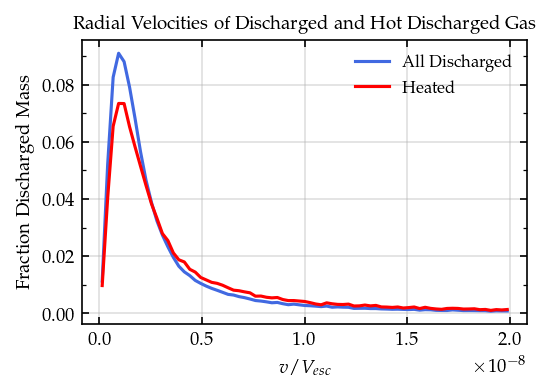

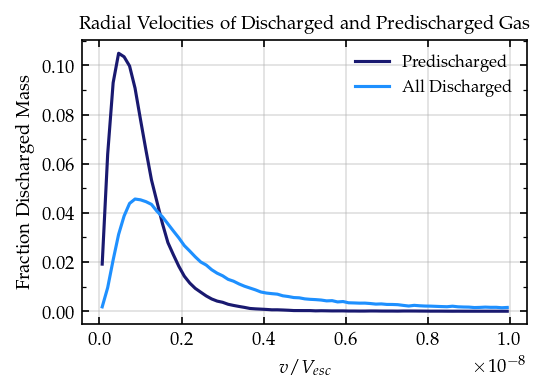

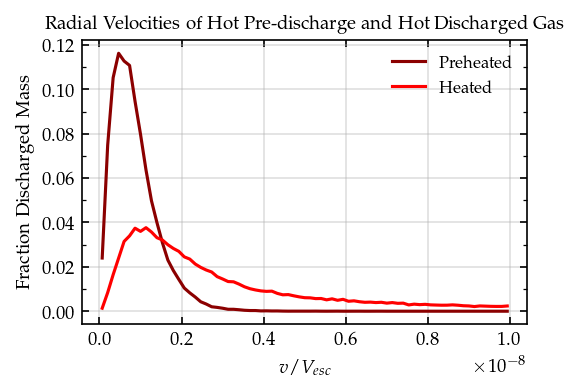

In [18]:
##### plotting all discharged vs. SNe-heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.

# all discharged.
y1, x = np.histogram(discharged.v_per_Vesc, bins=bins, weights=discharged.weight, range=(0, 2.0e-8))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='royalblue')

# sne-heated discharge.
y1, x = np.histogram(heated.v_per_Vesc, bins=bins, weights=heated.weight, range=(0, 2.0e-8))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Discharged and Hot Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{esc}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(-50,150)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1e10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting all discharged vs. gas pre-discharge #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# predischarged.
y1, x = np.histogram(predischarged.v_per_Vesc, bins=bins, weights=predischarged.weight, range=(0, 1.0e-8))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Predischarged', c='midnightblue')

# all discharged.
y1, x = np.histogram(discharged.v_per_Vesc, bins=bins, weights=discharged.weight, range=(0, 1.0e-8))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Discharged and Predischarged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{esc}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(-50,150)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05e10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')




##### plotting SNe-heated pre-discharged vs. SNe-heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


# sne-heated pre-discharge.
y1, x = np.histogram(preheated.v_per_Vesc, bins=bins, weights=preheated.weight, range=(0, 1.0e-8))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Preheated', c='darkred')

# sne-heated discharge.
y1, x = np.histogram(heated.v_per_Vesc, bins=bins, weights=heated.weight, range=(0, 1.0e-8))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Radial Velocities of Hot Pre-discharge and Hot Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{esc}$')
ax.set_ylabel('Fraction Discharged Mass')
# ax.set_xlim(-50,150)
# ax.set_ylim(0,0.2)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05e10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')

plt.show()

Well, based on observations for plotted ratios $v/V_{vir}$, the first plot is as we expect. However, for the second two, we see greater distinction between the pre- and post-discharge datasets with a greater portion of discharged particles having higher effective velocities than their predischarged counterparts.

## Fractions of SNe-heated ejecta per $R_{eff}$ <a class="anchor" id="fractional"></a>

____
____

In this section, we commit to determining the fraction of all discharged gas that is SNe-heated at different effective distances $R_{eff}$ (from the center of a particle's satellite galaxy) which we will define in this treatment as
$$
    R_{eff} = r/R_{vir},
$$
where $r$ is the radial distance of the particle from its respective satellite galaxy (stored in the callable key `r`), and $R_{vir}$ is the virial radius of said satellite designated by `r_Rvir` for each gas set. Then for each value $R_{eff}$, the fraction of SNe-heated discharged gas out of all discharged gas is computed.

[We also perform such analysis to determine the fraction of ram pressure-stripped gas to the total of discharged gas at each $r/R_{vir}$.This is then used to gauge whether SNe feedback may be engaging on its own, or if it is also acting alongside ram pressure stripping.] *Implementation coming*

### Fraction SNe-heated per $R_{eff}$ <a class="anchor" id="fractionsne"></a>


In [20]:
#ejected, cooled, expelled, accreted = read_all_ejected_expelled()
predischarged, discharged, accreted, preheated, heated = read_discharged()

h148_13 h148_278 h148_28 h148_283 h148_329 h148_37 h148_45 h148_68 h148_80 h229_20 h229_22 h229_23 h229_27 h229_55 h242_24 h242_41 h242_80 h329_137 h329_33
> Returning (predischarged, discharged, accreted, preheated, heated) for all available satellites <


In [46]:
# recalling weight attributes for plotting.
predischarged['weight'] = predischarged['mass'] / predischarged['mass'].sum()

discharged['weight'] = discharged['mass'] / discharged['mass'].sum()

accreted['weight'] = accreted['mass'] / accreted['mass'].sum()

preheated['weight'] = preheated['mass'] / preheated['mass'].sum()

heated['weight'] = heated['mass'] / heated['mass'].sum()

In [47]:
# data has precalculated key 'r_per_Rvir' that we will use for our position computations; we unpack it here.
pre_rR = predischarged.r_per_Rvir
all_rR = discharged.r_per_Rvir
acc_rR = accreted.r_per_Rvir
preh_rR = preheated.r_per_Rvir
hot_rR = heated.r_per_Rvir

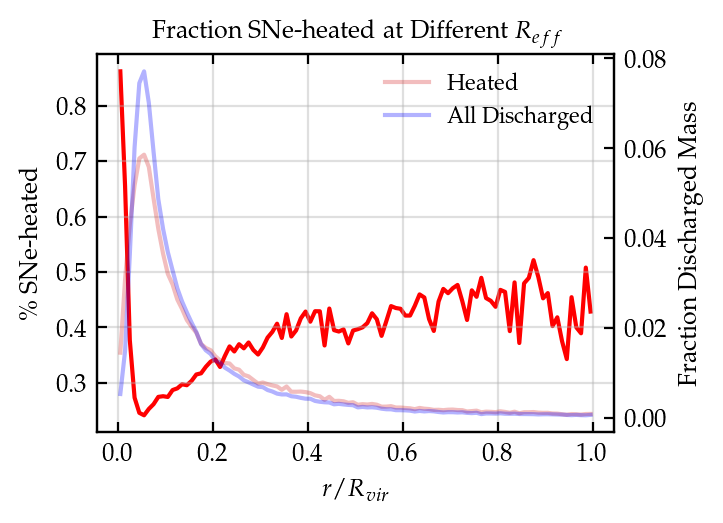

In [55]:
bins = 100
rangemax = 1.0

# assigning particles in each set to equal sets of bins.
_all, x = np.histogram(all_rR, bins=bins, range=(0,rangemax))

_hot, x = np.histogram(hot_rR, bins=bins, range=(0,rangemax))


# computing fraction hot/all for each bin.
sne_ratio = np.array([])

for i in range(0, bins):
    ratio = _hot[i]/_all[i]
    sne_ratio = np.append(sne_ratio, ratio)
    i += 1
    



### plotting fractions hot/all at different r/Rvir. ###
fig, ax1 = plt.subplots(1,1,dpi=200, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.

# fraction sne/all.
bincenters = 0.5*(x[1:] + x[:-1])
ax1.plot(bincenters, sne_ratio, label='SNe/All', c='r', zorder=-1000)

ax1.set_xlabel(r'$r/R_{vir}$')
ax1.set_ylabel('\% SNe-heated')
ax1.tick_params(axis ='y') 


# original sne, all distributions; adding twin axes to plot.
ax2 = ax1.twinx()

bins=100
y1, x = np.histogram(hot_rR, bins=bins, weights=heated.weight, range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='Heated', c='tab:red', alpha=0.3, zorder = -1)

y1, x = np.histogram(all_rR, bins=bins, weights=discharged.weight, range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='All Discharged', c='b', alpha=0.3, zorder=-1)


ax2.set_ylabel('Fraction Discharged Mass')  
ax2.tick_params(axis ='y') 


# labels, axis scaling, etc.
ax2.legend(frameon=False, fontsize='8')

ax1.set_title('Fraction SNe-heated at Different $R_{eff}$', fontsize='medium')
# ax1.set_xlim(0,0.6)
# ax1.set_ylim(-0.1,0.7)
# ax2.set_ylim(-0.005,0.1)


# ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
# ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
# ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
# ax1.tick_params(direction='in',which='both',right=True,top=True)
ax1.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')



### Fraction Ram Pressure-stripped per $r/R_{vir}$ <a class="anchor" id="fractionram"></a>



In [230]:
# saving for later.

## Accretion of Discharged Gas <a class="anchor" id="accretion"></a>

Answering the question of what fraction of discharged gas returns to its respective satellite galaxy's disk after expulsion. Furthermore, however, we determine what fraction of sne heated gas indeed returns to the disk.

Of course, our study here hinges on many dependencies: For one, results here depend entirely on how we count gas particle accretion. In the first stage of the analysis here, we simply look at the timestep* after a particle has been discharaged; if it has returned to its satellite's disk in the timestep after discharge, then we count it as being accreted. 

Analysis to be performed later on will require looking at all timesteps (or some yet to be defined 'sufficient number') to determine if the particle is ever accreted, since the original approach ignores the potential for accretion more than one timestep after discharge.

Let us start out simply by finding the ratio 
$$
    \frac{\# \ accreted}{\# \ discharged}
$$
where we only count unique accretion and discharge events (any particle that is repeatedly discharged and accreted is only counted once).

--

*Note that each step in time is defined to be 1 Gigayear.


In [56]:
# pulling out a subset of 'discharged' containing those discharged particles with pids that match the pids of those
# in 'accreted'; calling it 'accdis'; the masking technique.

# Ids of preheated
x = np.array(discharged['pid'])
# Ids of discharged, SNe heated gas
y = np.array(accreted['pid'])

index = np.argsort(x)
sorted_x = x[index] # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
accdis = discharged.iloc[result[~result.mask].data]

In [62]:
# looking for unique pids so that we don't doublecount particles that are discharged and accreted several times.

# ...for unique accreted...
m = np.zeros_like(accreted.pid, dtype=bool)
m[np.unique(accreted.pid, return_index=True)[1]] = True
acc_unique = accreted.pid[~m]

# ...for unique discharged...
m = np.zeros_like(discharged.pid, dtype=bool)
m[np.unique(discharged.pid, return_index=True)[1]] = True
dis_unique = discharged.pid[~m]

# computing percent accretion:
# print('According to the simulation data here collected,', "%.2f" % round(100 * len(acc_unique)/len(dis_unique),2),\
#       'percent of uniquely discharged particles are accreted back \n onto their respective satellite\'s halo/disk...' )

print('According to simulation data,', "%.2f" % round(100 * len(accreted)/len(discharged),2),\
      'percent of all discharged particles are accreted.' )

According to simulation data, 22.51 percent of all discharged particles are accreted.


In [63]:
# pulling out a subset of 'accreted' containing particles that were SNe-heated when discharged.

# Ids of preheated
x = np.array(accreted['pid'])
# Ids of discharged, SNe heated gas
y = np.array(heated['pid'])

index = np.argsort(x)
sorted_x = x[index] # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
accheated = accreted.iloc[result[~result.mask].data]

In [64]:
s = np.sort(heated.pid, axis=None)
x = s[:-1][s[1:] == s[:-1]]

s = np.sort(accheated.pid, axis=None)
y = s[:-1][s[1:] == s[:-1]]

len(x),len(y)

(15387, 11613)

In [69]:
# what about for heated particles?

# ...for unique accreted...
m = np.zeros_like(accheated.pid, dtype=bool)
m[np.unique(accheated.pid, return_index=True)[1]] = True
acc_unique = accheated.pid[~m]

# ...for unique heated...
m = np.zeros_like(heated.pid, dtype=bool)
m[np.unique(heated.pid, return_index=True)[1]] = True
hot_unique = heated.pid[~m]

# computing percent accretion:
# print('In the case of SNe-heated gas,', "%.2f" % round(100 * len(acc_unique)/len(hot_unique),2),\
#       'percent of uniquely discharged particles are accreted...' )

print('In the case of SNe-heated gas,', "%.2f" % round(100 * len(accheated)/len(heated),2),\
      'percent of all heated particles are accreted.' )

In the case of SNe-heated gas, 47.58 percent of all heated particles are accreted.


According to simulation data, 22.51 percent of all discharged particles are accreted.
In the case of SNe-heated gas, 47.58 percent of all heated particles are accreted.

Very interesting indeed. We certainly see that as might be expected, a greater percentage of SNe-heated discharged particles are accreted since these tend to stick closer to the center of their satellite host. However, in general, these percentages are notably low, indicative of the quenching we would expect to see?

--

Let us now consider the accretion rates for gas at different $R_{eff}$:

In [70]:
# coming soon.

## Code Testing <a class="anchor" id="proving"></a>

Testing out different data types and computations.

In [23]:
# computing radial bins; i.e. radii of rings of equal area.

# def radialbins(particles, bincount=50, max=False):
#     if max == False:
#         outer1 = particles.r_per_Rvir.max()/bincount
#     else:
#         outer1 = max/bincount
    
#     area = np.pi * (outer1)**2
#     bins = np.array([max/bincount])
    
#     for i in range(1, bincount-1):
#         outer = np.sqrt((i+1) * area / np.pi)
#         bins = np.append(bins, outer)
#         i += 1
        
#     return bins


# the above version does not give bins up to the maximum that we want, so we opt for this version below instead.
def radialbins(particles, bincount=50, max=False):
    if max == False:
        totalrad = particles.r_per_Rvir.max()
    else:
        totalrad = max
    
    bins = np.array([totalrad/bincount])
    
    for i in range(1, bincount):
        outer = totalrad * np.sqrt(i / bincount)
        bins = np.append(bins, outer)
        i += 1
        
    return bins

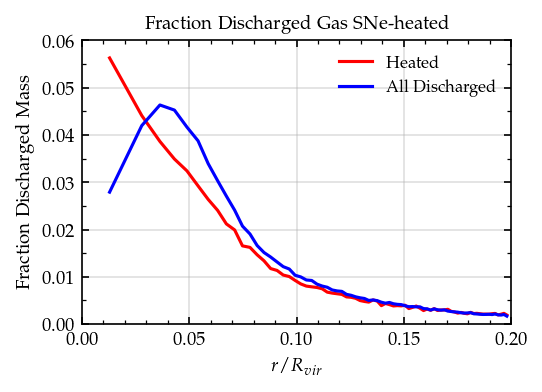

In [33]:
bincount = 75
bins = radialbins(discharged, bincount, 0.2)

### plotting heated r/Rvir alongside all discharged r/Rvir using the bining design defined above. ###
fig, ax = plt.subplots(1,1,dpi=150, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.


y1, x = np.histogram(hot_rR, bins=bins, weights=heated.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Heated', c='r')

y1, x = np.histogram(all_rR, bins=bins, weights=discharged.weight)
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='All Discharged', c='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Fraction Discharged Gas SNe-heated', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
ax.set_ylabel('Fraction Discharged Mass')
ax.set_xlim(0,0.2)
ax.set_ylim(0,0.06)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)
ax.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')

This binning strategy appears to work much better than when using numpy's standard binning technique; we will stick with this moving forward and confirm that it is a reasonable approach to take by making the above plot from the beginning of this notebook.

We now compute the fractions of discharged particles that were SNe-heated for each bin, and plot these fractions just as was done above for 'mass fractions.'

[0.02       0.14142136 0.2        0.24494897 0.28284271 0.31622777
 0.34641016 0.37416574 0.4        0.42426407 0.4472136  0.46904158
 0.48989795 0.50990195 0.52915026 0.54772256 0.56568542 0.58309519
 0.6        0.6164414  0.63245553 0.64807407 0.66332496 0.678233
 0.69282032 0.70710678 0.72111026 0.73484692 0.74833148 0.76157731
 0.77459667 0.78740079 0.8        0.81240384 0.82462113 0.83666003
 0.84852814 0.86023253 0.87177979 0.88317609 0.89442719 0.90553851
 0.91651514 0.92736185 0.93808315 0.9486833  0.9591663  0.96953597
 0.9797959  0.98994949]


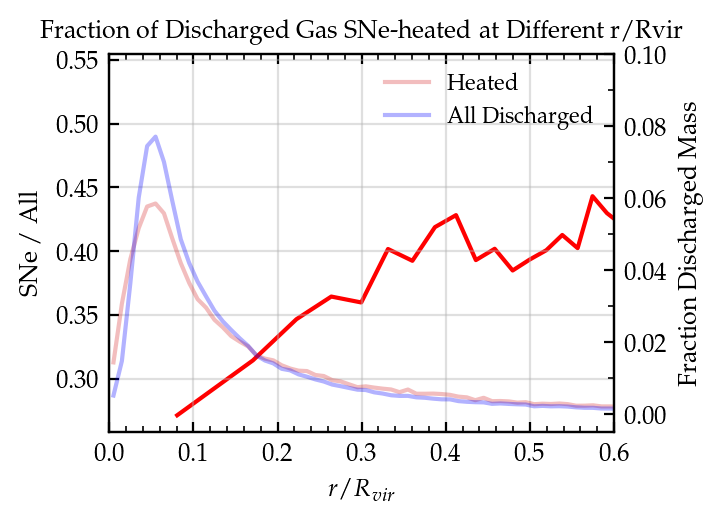

In [54]:
bincount = 50
rangemax = 1.0

bins = radialbins(discharged, bincount, rangemax)
bincenters = 0.5*(bins[1:] + bins[:-1])


# assigning particles in each set to equal sets of bins.
_all, x = np.histogram(all_rR, bins=bins)

_hot, x = np.histogram(hot_rR, bins=bins)

# computing fraction hot/all for each bin.
sne_ratio = np.array([])

for i in range(0, bincount-1):
    ratio = _hot[i]/_all[i]
    sne_ratio = np.append(sne_ratio, ratio)
    i += 1
    
print(bins)


### plotting fractions hot/all at different r/Rvir. ###
fig, ax1 = plt.subplots(1,1,dpi=200, figsize=(3.5,2.5), constrained_layout=True) # change to dpi=300 for printout.

# fraction sne/all.
ax1.plot(bincenters, sne_ratio, label='SNe/All', c='r', zorder=-1000)

ax1.set_xlabel(r'$r/R_{vir}$')
ax1.set_ylabel('SNe / All')
ax1.tick_params(axis ='y') 


# original sne, all distributions; adding twin axes to plot.
ax2 = ax1.twinx()

bins=100
y1, x = np.histogram(hot_rR, bins=bins, weights=heated.weight, range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='Heated', c='tab:red', alpha=0.3, zorder = -1)

y1, x = np.histogram(all_rR, bins=bins, weights=discharged.weight, range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='All Discharged', c='b', alpha=0.3, zorder=-1)


ax2.set_ylabel('Fraction Discharged Mass')  
ax2.tick_params(axis ='y') 


# labels, axis scaling, etc.
ax2.legend(frameon=False, fontsize='8')

ax1.set_title('Fraction of Discharged Gas SNe-heated at Different r/Rvir', fontsize='medium')
ax1.set_xlim(0,0.6)
# ax1.set_ylim(-0.1,0.7)
ax2.set_ylim(-0.005,0.1)


ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
# ax1.tick_params(direction='in',which='both',right=True,top=True)
ax1.grid(alpha=0.4, zorder=-1000)

# plt.savefig('plots/theta_allsats_stacked.pdf')

We calculate the same plot given above in the proceeding to compare the dynamic vs standard histogram binning. Evidently, the dynamic version would appear more useful.